<a href="https://colab.research.google.com/github/SanjaraT/Diabetes_Retinopathy_Detection/blob/main/Capstone01.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.
import kagglehub
sovitrath_diabetic_retinopathy_224x224_gaussian_filtered_path = kagglehub.dataset_download('sovitrath/diabetic-retinopathy-224x224-gaussian-filtered')

print('Data source import complete.')


100%|██████████| 427M/427M [00:08<00:00, 54.3MB/s]

Extracting files...


Data source import complete.


In [ ]:
!pip install matplotlib-venn

In [ ]:
from tensorflow import lite
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import pandas as pd
import random, os
import shutil
import matplotlib.pyplot as plt
from matplotlib.image import imread
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import categorical_accuracy
from sklearn.model_selection import train_test_split

In [ ]:
# Add an additional column, mapping to the type
df = pd.read_csv(r'/content/drive/MyDrive/train.csv')

diagnosis_dict_binary = {
    0: 'No_DR',
    1: 'DR',
    2: 'DR',
    3: 'DR',
    4: 'DR'
}

diagnosis_dict = {
    0: 'No_DR',
    1: 'Mild',
    2: 'Moderate',
    3: 'Severe',
    4: 'Proliferate_DR',
}


df['binary_type'] =  df['diagnosis'].map(diagnosis_dict_binary.get)
df['type'] = df['diagnosis'].map(diagnosis_dict.get)
df.head()

,id_code,diagnosis,binary_type,type
0,000c1434d8d7,2,DR,Moderate
1,001639a390f0,4,DR,Proliferate_DR
2,0024cdab0c1e,1,DR,Mild
3,002c21358ce6,0,No_DR,No_DR
4,005b95c28852,0,No_DR,No_DR


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


<Axes: ylabel='type'>

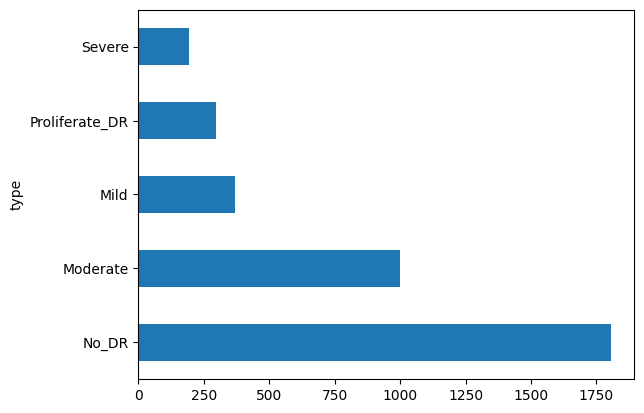

In [ ]:
df['type'].value_counts().plot(kind='barh')

<Axes: ylabel='binary_type'>

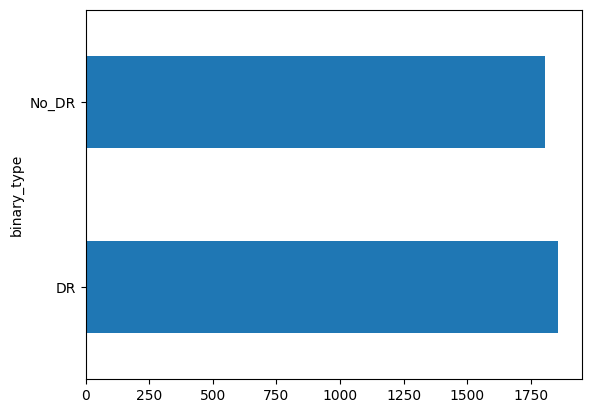

In [ ]:
df['binary_type'].value_counts().plot(kind='barh')

In [ ]:
# Split into stratified train, val, and test sets
train_intermediate, val = train_test_split(df, test_size = 0.15, stratify = df['type'])
train, test = train_test_split(train_intermediate, test_size = 0.15 / (1 - 0.15), stratify = train_intermediate['type'])

print(train['type'].value_counts(), '\n')
print(test['type'].value_counts(), '\n')
print(val['type'].value_counts(), '\n')


type
No_DR             1263
Moderate           699
Mild               258
Proliferate_DR     207
Severe             135
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 

type
No_DR             271
Moderate          150
Mild               56
Proliferate_DR     44
Severe             29
Name: count, dtype: int64 



In [ ]:
# Create working directories for train/val/test
base_dir = ''

train_dir = os.path.join(base_dir, 'train')
val_dir = os.path.join(base_dir, 'val')
test_dir = os.path.join(base_dir, 'test')

if os.path.exists(base_dir):
    shutil.rmtree(base_dir)

if os.path.exists(train_dir):
    shutil.rmtree(train_dir)
os.makedirs(train_dir)

if os.path.exists(val_dir):
    shutil.rmtree(val_dir)
os.makedirs(val_dir)

if os.path.exists(test_dir):
    shutil.rmtree(test_dir)
os.makedirs(test_dir)


In [ ]:
# Copy images to respective working directory
src_dir = r'/content/drive/MyDrive/gaussian_filtered_images/gaussian_filtered_images'
for index, row in train.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(train_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in val.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(val_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)

for index, row in test.iterrows():
    diagnosis = row['type']
    binary_diagnosis = row['binary_type']
    id_code = row['id_code'] + ".png"
    srcfile = os.path.join(src_dir, diagnosis, id_code)
    dstfile = os.path.join(test_dir, binary_diagnosis)
    os.makedirs(dstfile, exist_ok = True)
    shutil.copy(srcfile, dstfile)


In [ ]:
# Setting up ImageDataGenerator for train/val/test

train_path = 'train'
val_path = 'val'
test_path = 'test'

train_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(train_path, target_size=(224,224), shuffle = True)
val_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(val_path, target_size=(224,224), shuffle = True)
test_batches = ImageDataGenerator(rescale = 1./255).flow_from_directory(test_path, target_size=(224,224), shuffle = False)


Found 2562 images belonging to 2 classes.
Found 550 images belonging to 2 classes.
Found 550 images belonging to 2 classes.


In [ ]:
# Building the model
from tensorflow.keras.optimizers import Adam

model = tf.keras.Sequential([
    layers.Conv2D(8, (3,3), padding="valid", input_shape=(224,224,3), activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(16, (3,3), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Conv2D(32, (4,4), padding="valid", activation = 'relu'),
    layers.MaxPooling2D(pool_size=(2,2)),
    layers.BatchNormalization(),

    layers.Flatten(),
    layers.Dense(32, activation = 'relu'),
    layers.Dropout(0.15),
    layers.Dense(2, activation = 'softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate = 0.00001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['acc'])

history = model.fit(train_batches,
                    epochs=30,
                    validation_data=val_batches)

Epoch 1/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 109s 1s/step - acc: 0.6600 - loss: 0.7353 - val_acc: 0.5073 - val_loss: 0.6855
Epoch 2/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 94s 1s/step - acc: 0.8924 - loss: 0.2818 - val_acc: 0.5073 - val_loss: 0.6678
Epoch 3/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 140s 1s/step - acc: 0.9045 - loss: 0.2516 - val_acc: 0.6073 - val_loss: 0.6113
Epoch 4/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - acc: 0.9178 - loss: 0.2280 - val_acc: 0.8200 - val_loss: 0.4991
Epoch 5/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 91s 1s/step - acc: 0.9208 - loss: 0.2373 - val_acc: 0.9018 - val_loss: 0.3818
Epoch 6/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 142s 1s/step - acc: 0.9325 - loss: 0.1976 - val_acc: 0.9200 - val_loss: 0.2938
Epoch 7/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 90s 1s/step - acc: 0.9286 - loss: 0.1893 - val_acc: 0.9309 - val_loss: 0.2349
Epoch 8/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 143s 1s/step - acc: 0.9492 - loss: 0.1737 - val_acc: 0.9273 - val_loss: 0.2001
Epoch 9/30
81/81 ━━━━━━━━━━━━━━━━━━━━ 138s 1s/step - acc: 0.9426 - l

In [ ]:
model.save('64x3-CNN.model.keras')

In [ ]:
loss , acc= model.evaluate(test_batches, verbose=1)
#print("Loss: ", loss)
print("Accuracy: ", acc)


18/18 ━━━━━━━━━━━━━━━━━━━━ 8s 431ms/step - acc: 0.9049 - loss: 0.2509
Accuracy:  0.9254545569419861


# ****Diabet Retinopathy Detection Section****

In [ ]:
import tensorflow as tf
import cv2
import numpy as np
import matplotlib.pyplot as plt


def predict_class(path):
    img = cv2.imread(path)

    RGBImg = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    RGBImg= cv2.resize(RGBImg,(224,224))
    plt.imshow(RGBImg)
    image = np.array(RGBImg) / 255.0

    new_model = tf.keras.models.load_model("64x3-CNN.model.keras")
    predict=new_model.predict(np.array([image]))
    per=np.argmax(predict,axis=1)
    if per==1:
        print('No DR')
    else:
        print('DR')




1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step
DR


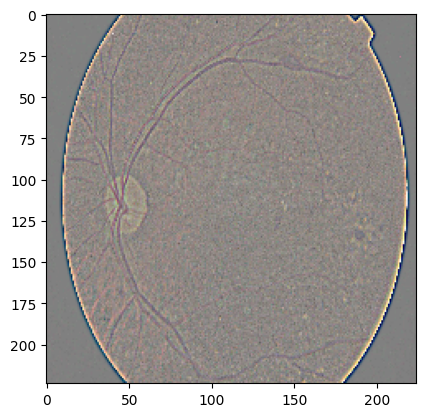

In [ ]:
predict_class('/content/drive/MyDrive/gaussian_filtered_images/gaussian_filtered_images/Severe/03c85870824c.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 209ms/step
No DR


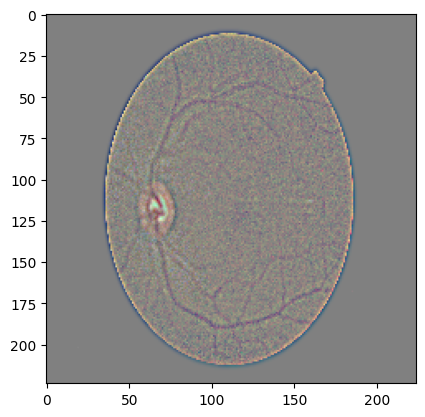

In [ ]:
predict_class('/content/drive/MyDrive/gaussian_filtered_images/gaussian_filtered_images/No_DR/005b95c28852.png')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step
DR


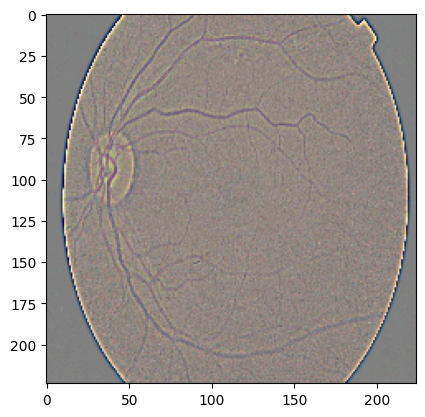

In [ ]:
predict_class('/content/drive/MyDrive/gaussian_filtered_images/gaussian_filtered_images/Mild/00cb6555d108.png')